In [206]:
import os
import configparser

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from generativepy.color import Color
from PIL import ImageColor

from matplotlib import font_manager

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

# Load world countries shapefile

In [110]:
# load countries shapefile
file = "ne_10m_admin_0_countries"
countries = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\%s\\%s.shp" %(file, file)))

#rename incorrect ISO code for South Sudan
countries.loc[countries["ADMIN"]=="South Sudan", "ADM0_A3"] = "SSD"

print(len(countries))
countries.head()

258


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


# Create colormap

Followed [this guide](https://waterprogramming.wordpress.com/2022/09/08/bivariate-choropleth-maps/) to create a bivariate colormap in python. 

In [271]:
### percentile bounds defining upper boundaries of color classes
percentile_bounds = [25, 75, 100]

### function to convert hex color to rgb to Color object (generativepy package)
def hex_to_Color(hexcode):
    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v/256 for v in rgb]
    rgb = Color(*rgb)
    return rgb

### get corner colors from https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
c00 = hex_to_Color('#d8d8d8') #lower bottom
c10 = hex_to_Color('#c85a5a') #top left
c01 = hex_to_Color('#64acbe') #lower right
c11 = hex_to_Color('#574249') #upper right

#Purple/turquoise version
#c00 = hex_to_Color('#d8d8d8') #lower bottom
#c10 = hex_to_Color('#be64ac') #top left
#c01 = hex_to_Color('#5ac8c8') #lower right
#c11 = hex_to_Color('#3b4994') #upper right

### now create square grid of colors, using color interpolation from generativepy package
num_grps = len(percentile_bounds)
c00_to_c10 = []
c01_to_c11 = []
colorlist = []
for i in range(num_grps):
    c00_to_c10.append(c00.lerp(c10, 1/(num_grps-1) * i))
    c01_to_c11.append(c01.lerp(c11, 1/(num_grps-1) * i))
for i in range(num_grps):
    for j in range(num_grps):
        colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1/(num_grps-1) * j))
        
### convert back to hex color
colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]

In [268]:
### function to get bivariate color given two percentiles
def get_bivariate_choropleth_color(p1, p2):
    if p1>=0 and p2>=0:
        count = 0
        stop = False
        for percentile_bound_p1 in percentile_bounds:
            for percentile_bound_p2 in percentile_bounds:
                if (not stop) and (p1 <= percentile_bound_p1):
                    if (not stop) and (p2 <= percentile_bound_p2):
                        color = colorlist[count]
                        stop = True
                count += 1
    else:
        color = [0.6,0.6,0.6,1]
    return color

# Define font styles

In [16]:
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Bold.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-SemiBold.otf')
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Medium.otf')

# Meat consumption vs GDP

In [130]:
consum = pd.read_csv("meat-consumption-vs-gdp-per-capita.csv")
consum = consum.rename(columns={"Meat food supply quantity (kg/capita/yr) (FAO, 2020)":"meat_supply_per_capita",
                               "GDP per capita, PPP (constant 2017 international $)": "GDP_per_capita"})
consum = consum[consum["Year"]==2017]
consum = consum.dropna(subset=["meat_supply_per_capita", "GDP_per_capita"])
consum['meat_supply_percentiles'] = pd.qcut(consum["meat_supply_per_capita"], 10, labels=np.arange(10,110,10)).astype(int)
consum['GDP_percentiles'] = pd.qcut(consum["GDP_per_capita"], 10, labels=np.arange(10,110,10)).astype(int)
consum['meat_supply_quartiles'] = pd.qcut(consum["meat_supply_per_capita"], 4, labels=np.arange(25,125,25)).astype(int)
consum['GDP_quartiles'] = pd.qcut(consum["GDP_per_capita"], 4, labels=np.arange(25,125,25)).astype(int)
#consum["Code"] = consum["Code"].str.replace("COG", "COD")
print(len(consum))
consum.head()

165


,Entity,Code,Year,meat_supply_per_capita,GDP_per_capita,Population (historical estimates),Continent,meat_supply_percentiles,GDP_percentiles,meat_supply_quartiles,GDP_quartiles
57,Afghanistan,AFG,2017,8.59,2058.400146,35643420.0,NaN,10,10,25,25
576,Albania,ALB,2017,47.51,12770.963867,2879361.0,NaN,60,50,75,50
835,Algeria,DZA,2017,18.06,11737.401367,41136548.0,NaN,30,50,25,50
1520,Angola,AGO,2017,23.49,7310.896484,30208634.0,NaN,30,40,50,50
1904,Antigua and Barbuda,ATG,2017,72.04,19840.283203,91133.0,NaN,80,70,100,75


In [131]:
_countries = countries.copy()
_countries["ADM0_A3"] = _countries["ADM0_A3"].str.replace("COD", "COG")

gdf = pd.merge(_countries[['featurecla','SOVEREIGNT','SOV_A3','ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
                           'ADM0_A3', "geometry"]],
               consum[["Code",  'meat_supply_percentiles', 'GDP_percentiles', 'meat_supply_quartiles', 'GDP_quartiles']],
               left_on="ADM0_A3", right_on="Code", how="left")

gdf["area_size"] = gdf["geometry"].area

## Map

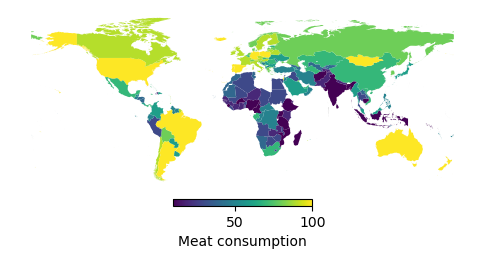

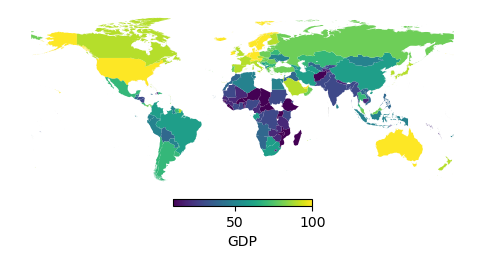

In [106]:
label_dict = {'meat_supply_percentiles': 'Meat consumption', 
              'GDP_percentiles': 'GDP'}
alpha=1
 
for attr, label in label_dict.items():
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    gdf.plot(attr, ax=ax, alpha=alpha,  legend=True, 
             legend_kwds={'label':label, 'orientation':'horizontal', 'shrink': 0.3, 'pad': 0.03, 'alpha':alpha})
    ax.axis("off")

In [269]:
#reverse percentiles and get bivariate colours
v1 = 'meat_supply_quartiles'
v2 = 'GDP_quartiles'
gdf['color_bivariate'] = [get_bivariate_choropleth_color(p1, p2) for p1,p2 
                          in zip(gdf[v1].values, gdf[v2].values)]

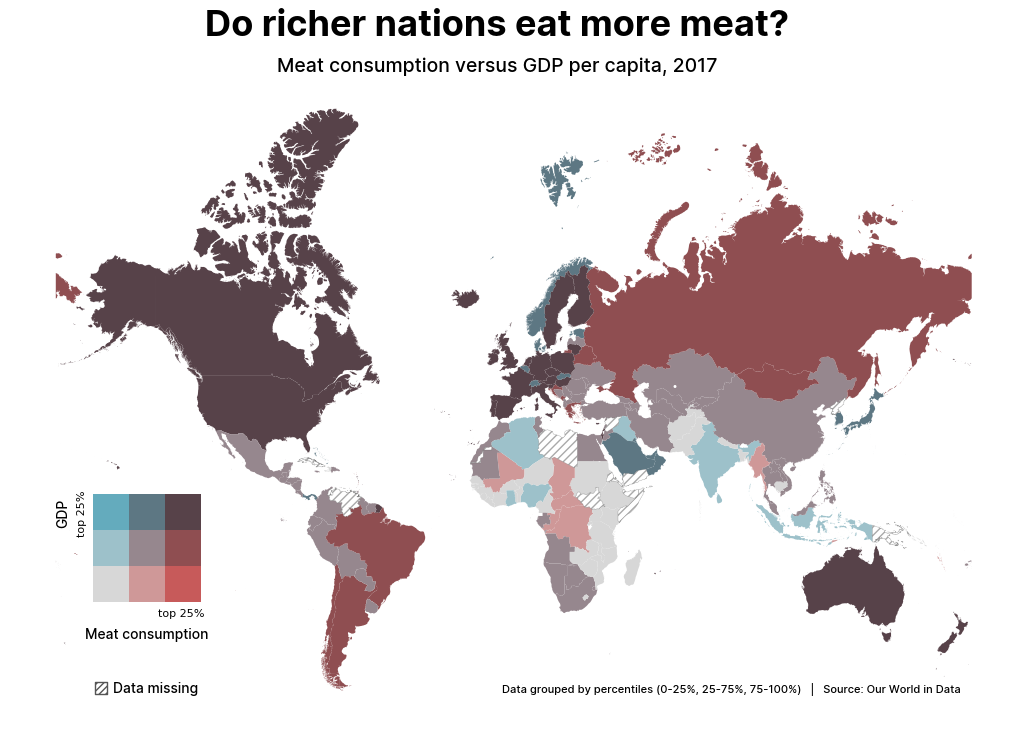

In [272]:
labels = {v1: "Meat consumption", v2: "GDP"}

### plot map based on bivariate choropleth
fig, ax = plt.subplots(1,1, figsize=(13,9))

gdf = gdf.to_crs(3857)
attr = 'meat_supply_percentiles'
gdf.loc[gdf[attr] >= 0].plot(ax=ax, color=gdf.loc[gdf[attr] >= 0]['color_bivariate'])

#plot countries with missing data
gdf.loc[(gdf[attr].isna()) & (gdf["area_size"] <=2061938970167) & 
        (gdf["area_size"] >=51652469000)].plot(ax=ax, color="white", edgecolor="#555555",
                                               linewidth=0.3, hatch='////', alpha=0.5)

ax.axis("off")

### create legend
ax1 = fig.add_axes([0.17,0.27, 0.12,0.12], zorder=1)
ax1.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i, percentile_bound_p1 in enumerate(percentile_bounds):
    for j, percentile_bound_p2 in enumerate(percentile_bounds):
        percentileboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(percentileboxes, facecolor=colorlist[count], alpha=alpha)
        count += 1
        ax1.add_collection(pc)
        if i == 0:
            yticks.append(percentile_bound_p2)
    xticks.append(percentile_bound_p1)

ax1.set_xlim([0,len(percentile_bounds)])
ax1.set_ylim([0,len(percentile_bounds)])
ax1.set_xlabel('                    top 25%', fontsize=8)
ax1.set_ylabel('                    top 25%', fontsize=8)
ax1.text(1.5,-1., labels[v1], ha="center", fontproperties=label_font,fontsize=10)
ax1.text(-1.,2.5, labels[v2], va="center", rotation=90,fontproperties=label_font,fontsize=10)

ax1.set_xticks([])
ax1.set_yticks([])
for pos in ["top", "bottom", "left", "right"]:
    ax1.spines[pos].set_visible(False)

## Title and footer
plt.figtext(0.5, 0.9, "Do richer nations eat more meat?", fontproperties= title_font, fontsize=26,  ha="center")
plt.figtext(0.5, 0.86, "Meat consumption versus GDP per capita, 2017",
            linespacing=1.5,fontproperties=label_font, fontsize=14, ha="center")
plt.figtext(0.68, 0.17, "Data grouped by percentiles (0-25%, 25-75%, 75-100%)   |   Source: Our World in Data", 
            fontproperties=label_font, fontsize=8, ha="center", linespacing=2)

## Fake legend for missing data
ax2 = fig.add_axes([0.17,0.15, 0.05,0.05], zorder=1)
ax2.scatter(1,1, marker="s", s=75, facecolor="white", edgecolor="#555555", hatch='/////')
ax2.text(1.02,1,"Data missing", va="center", fontproperties=label_font, fontsize=10)
ax2.axis("off")

plt.savefig("meatconsumption-gdp-bivariate-map-redblue.png", dpi=300, bbox_inches='tight', pad_inches=0.15)

plt.show()

# Corruption vs Press Freedom

## load data to plot





In [6]:
corruption = pd.read_csv("corruption-perception-index.csv")
corruption = corruption[corruption["Year"]==2018]
corruption = corruption.rename(columns={"Corruption Perception Index - Transparency International (2018)":
                                        "corruption_index"})
corruption['corruption_percentiles'] = pd.qcut(corruption["corruption_index"], 10, labels=np.arange(10,110,10)).astype(int)
corruption['corruption_quartiles'] = pd.qcut(corruption["corruption_index"], 4, labels=np.arange(25,125,25)).astype(int)
print(len(corruption))
corruption.head()

180


,Entity,Code,Year,corruption_index,corruption_percentiles,corruption_quartiles
6,Afghanistan,AFG,2018,16,10,25
13,Albania,ALB,2018,36,50,50
20,Algeria,DZA,2018,35,40,50
27,Angola,AGO,2018,19,10,25
34,Argentina,ARG,2018,40,60,75


In [7]:
pressfreedom = pd.read_csv("press-freedom-index-2022.csv", delimiter=";", decimal=",")
pressfreedom = pressfreedom.dropna(subset="Score N")
pressfreedom['pressfreedom_percentiles'] = pd.qcut(pressfreedom["Score N"], 10, labels=np.arange(10,110,10)).astype(int)
pressfreedom['pressfreedom_quartiles'] = pd.qcut(pressfreedom["Score N"], 4, labels=np.arange(25,125,25)).astype(int)
print(len(pressfreedom))
pressfreedom.head()

180


,ISO,Score N,Rank N,Political Context,Rank_Pol,Economic Context,Rank_Eco,Legal Context,Rank_Leg,Social Context,...,Country_EN,Country_FR,Country_ES,Country_AR,Country_FA,Year (N),Rank N-1,"Rank evolution,,,,,,",pressfreedom_percentiles,pressfreedom_quartiles
1,NOR,92.65,1.0,94.89,1.0,90.38,1.0,92.23,1.0,93.71,...,Norway,Norvège,Noruega,النرويج,نروژ,2022.0,1.0,0,100,100
3,DNK,90.27,2.0,94.34,2.0,83.67,3.0,89.18,4.0,91.17,...,Denmark,Danemark,Dinamarca,الدنمارك,دانمارک,2022.0,4.0,2,100,100
5,SWE,88.84,3.0,91.96,3.0,87.66,2.0,90.27,3.0,90.18,...,Sweden,Suède,Suecia,السويد,سوئد,2022.0,3.0,0,100,100
7,EST,88.83,4.0,91.11,5.0,81.97,6.0,87.87,5.0,90.00,...,Estonia,Estonie,Estonia,إستونيا,استونی,2022.0,15.0,"11,",100,100
9,FIN,88.42,5.0,90.40,6.0,82.03,5.0,86.64,9.0,90.77,...,Finland,Finlande,Finlandia,فنلندا,فنلاند,2022.0,2.0,-3,100,100


## Merge data + explore

In [8]:
gdf = pd.merge(countries[['featurecla','SOVEREIGNT','SOV_A3','ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
                           'ADM0_A3', "geometry"]],
               corruption[["Code", "corruption_index", "corruption_percentiles", "corruption_quartiles"]],
               left_on="ADM0_A3", right_on="Code", how="left")
gdf = pd.merge(gdf, pressfreedom[['ISO', 'Score N','pressfreedom_percentiles', 'pressfreedom_quartiles']], 
              left_on="ADM0_A3", right_on="ISO", how="left")

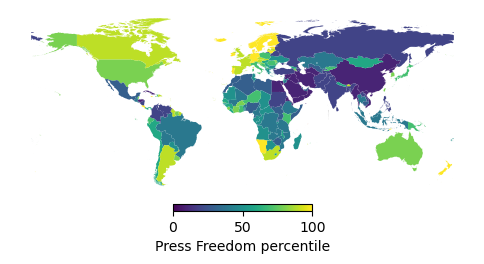

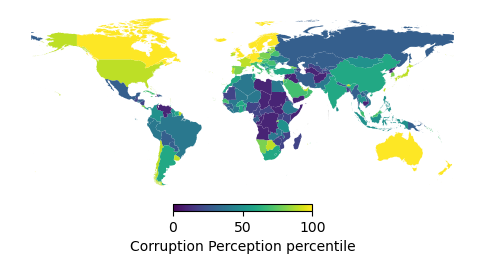

In [10]:
label_dict = {'pressfreedom_percentiles': 'Press Freedom percentile', 
              'corruption_percentiles': 'Corruption Perception percentile'}
alpha=1
 
for attr, label in label_dict.items():
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    gdf.loc[gdf[attr] >= 0].plot(attr, ax=ax, alpha=alpha, vmin=0, legend=True, 
             legend_kwds={'label':label, 'orientation':'horizontal', 'shrink': 0.3, 'pad': 0.03, 'alpha':alpha})
    ax.axis("off")

In [11]:
#reverse percentiles and get bivariate colours
gdf['pressfreedom_percentiles_r'] = [100 - quartile + 10 for quartile in gdf['pressfreedom_percentiles']] 
gdf['corruption_percentiles_r'] = [100 - quartile + 10 for quartile in gdf['corruption_percentiles']] 
gdf['color_bivariate'] = [get_bivariate_choropleth_color(p1, p2) for p1,p2 
                          in zip(gdf['pressfreedom_percentiles_r'].values, gdf['corruption_percentiles_r'].values)]

## Plot bivariate map


In [12]:
#gdf = gdf.to_crs(900913)
#gdf = gdf.to_crs(4326)
gdf = gdf.to_crs(3857)

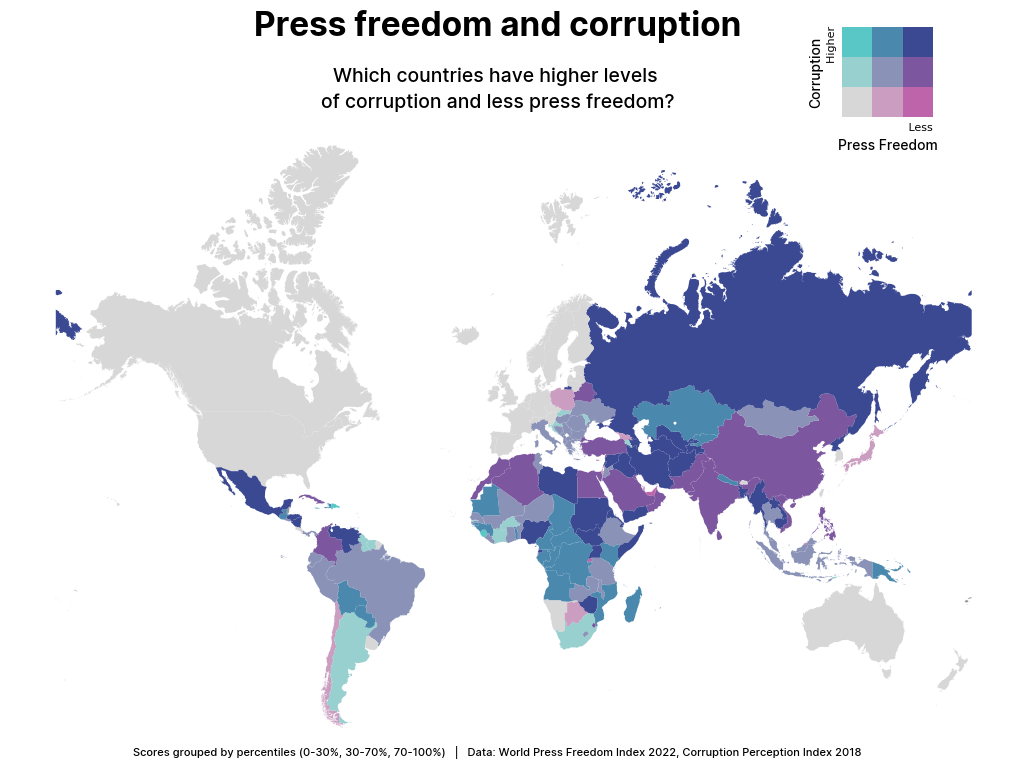

In [63]:
### plot map based on bivariate choropleth
fig, ax = plt.subplots(1,1, figsize=(13,9))

attr = 'pressfreedom_quartiles'
gdf.loc[gdf[attr] >= 0].plot(ax=ax, color=gdf.loc[gdf[attr] >= 0]['color_bivariate'], alpha=alpha, legend=False)
ax.axis("off")

### create legend
ax1 = fig.add_axes([0.75,0.85, 0.1,0.1], zorder=1)
ax1.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i, percentile_bound_p1 in enumerate(percentile_bounds):
    for j, percentile_bound_p2 in enumerate(percentile_bounds):
        percentileboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(percentileboxes, facecolor=colorlist[count], alpha=alpha)
        count += 1
        ax1.add_collection(pc)
        if i == 0:
            yticks.append(percentile_bound_p2)
    xticks.append(percentile_bound_p1)

ax1.set_xlim([0,len(percentile_bounds)])
ax1.set_ylim([0,len(percentile_bounds)])
ax1.set_xlabel('                   Less', fontsize=8)
ax1.set_ylabel('                Higher', fontsize=8)
ax1.text(1.5,-1.1, "Press Freedom", ha="center", fontproperties=label_font,)
ax1.text(-1.1,1.5, "Corruption", va="center", rotation=90,fontproperties=label_font,)

ax1.set_xticks([])
ax1.set_yticks([])
for pos in ["top", "bottom", "left", "right"]:
    ax1.spines[pos].set_visible(False)

## Title and footer
plt.figtext(0.5, 0.94, "Press freedom and corruption", fontproperties= title_font, fontsize=24,  ha="center")
plt.figtext(0.5, 0.86, "Which countries have higher levels \nof corruption and less press freedom?",
            linespacing=1.5,fontproperties=label_font, fontsize=14, ha="center")
plt.figtext(0.5, 0.14, "Scores grouped by percentiles (0-30%, 30-70%, 70-100%)   |   Data: World Press Freedom Index 2022, Corruption Perception Index 2018", 
            fontproperties=label_font, fontsize=8, ha="center", linespacing=2)

plt.savefig("Pressfreedom-vs-corruption-bivariate-map.png", dpi=300, bbox_inches='tight', pad_inches=0.15)

plt.show()

# Archive

In [89]:
test = pd.merge(countries[['featurecla','SOVEREIGNT','SOV_A3','ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
                           'ADM0_A3', "geometry"]],
                corruption[["Code", "corruption_index", "corruption_percentiles"]],
               left_on="ADM0_A3", right_on="Code", how="right")
test[test["ADM0_A3"].isna()]

,featurecla,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,ADM0_A3,geometry,Code,corruption_index,corruption_percentiles
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,OWID_KOS,37,5


In [88]:
test = pd.merge(countries[['featurecla','SOVEREIGNT','SOV_A3','ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
                           'ADM0_A3', "geometry"]],
                pressfreedom[['ISO', 'Score N','pressfreedom_percentiles',  'Country_EN']], 
              left_on="ADM0_A3", right_on="ISO", how="right")
test[test["ADM0_A3"].isna()]

,featurecla,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,ADM0_A3,geometry,ISO,Score N,pressfreedom_percentiles,Country_EN
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,XCD,68.49,7,OECS
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,XKO,67.00,7,Kosovo
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,CTU,61.08,6,Cyprus North
169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,PSE,28.98,1,Palestine


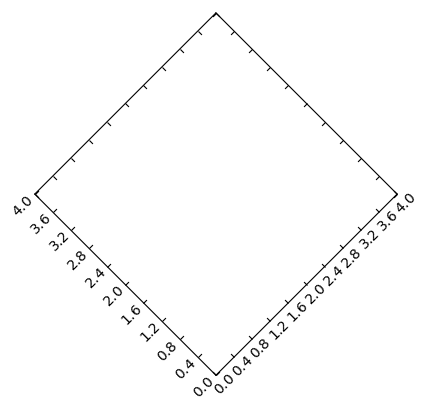

In [238]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

fig = plt.figure()

plot_extents = 0, 4, 0, 4
transform = Affine2D().rotate_deg(45)
helper = floating_axes.GridHelperCurveLinear(transform, plot_extents)
ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)


fig.add_subplot(ax)

plt.show()